In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import segmentation_models_pytorch as smp
import torch
import torchvision as tv
from PIL import Image

# print version of each librarie : 
print(f"torch : {torch.__version__}")
print(f"torchvision : {tv.__version__}")
print(f"segmentation_models_pytorch : {smp.__version__}")
# print cuda version if available
if torch.cuda.is_available():
    print(f"cuda version : {torch.version.cuda}")

# print python version
import sys
print(f"python : {sys.version}")


torch : 1.13.0+cu116
torchvision : 0.14.0+cu116
segmentation_models_pytorch : 0.3.3
cuda version : 11.6
python : 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]


In [3]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from Model.DataLoader import DataLoaderManager
from Model.Train import Trainer
from Model.Loss import Loss
from Model.Test import Tester

In [4]:
def calculate_f1score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

In [5]:
model_with_bce = torch.load("../res/model_metrics/model_with_bce/model_ENB3_BCE_balanced_augmented_3D")
model_wtih_bce_50 = torch.load("../res/model_metrics/model_with_bce_50/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice = torch.load("../res/model_metrics/model_with_bce_dice/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_1e3 = torch.load("../res/model_metrics/model_with_bce_dice_1e3/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_1e5 = torch.load("../res/model_metrics/model_with_bce_dice_1e5/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_50 = torch.load("../res/model_metrics/model_with_bce_dice_50/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_b8 = torch.load("../res/model_metrics/model_with_bce_dice_b8/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_b32 = torch.load("../res/model_metrics/model_with_bce_dice_b32/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_inv = torch.load("../res/model_metrics/model_with_bce_dice_inv/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_no_aug = torch.load("../res/model_metrics/model_with_bce_dice_no_aug/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_dice_no_weight = torch.load("../res/model_metrics/model_with_bce_dice_no_weight/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_focal_dice = torch.load("../res/model_metrics/model_with_focal_dice/model_ENB3_FOCAL_DICE_balanced_augmented_3D")
model_with_tswerky = torch.load("../res/model_metrics/model_with_tswerky/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_focal_dice = torch.load("../res/model_metrics/model_with_bce_focal_dice/model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_focal_dice_inv = torch.load("../res/model_metrics/model_with_bce_focal_dice/inv_model_ENB3_BCE_DICE_balanced_augmented_3D")
model_with_bce_focal_dice_no_weight = torch.load("../res/model_metrics/model_with_bce_focal_dice/model_ENB3_BCE_DICE_balanced_augmented_3D_no_weight")
model_with_focal_dice_MIT = torch.load("../res/model_metrics/model_with_focal_dice_MIT/model_MITB4_FOCAL_DICE_balanced_augmented_3D")
model_with_focal_dice_RES = torch.load("../res/model_metrics/model_with_focal_dice_res/model_RES34_FOCAL_DICE_balanced_augmented_3D")

In [6]:
all_model = [
    model_with_bce,
    model_wtih_bce_50,
    model_with_bce_dice,
    model_with_bce_dice_1e3,
    model_with_bce_dice_1e5,
    model_with_bce_dice_50,
    model_with_bce_dice_b8,
    model_with_bce_dice_b32, #7
    model_with_bce_dice_inv,
    model_with_bce_dice_no_aug,
    model_with_bce_dice_no_weight,
    model_with_focal_dice, ##11
    model_with_tswerky, #12
    model_with_bce_focal_dice,
    model_with_bce_focal_dice_inv,
    model_with_bce_focal_dice_no_weight,
    model_with_focal_dice_MIT,
    model_with_focal_dice_RES
]

In [7]:
model_t = torch.load("../res/model_metrics/model_RES34_FOCAL_DICE_balanced_augmented_3D")
precision = model_t["validation"]["precision"][-1]
recall = model_t["validation"]["recall"][-1]
f1_score = calculate_f1score(precision, recall)
print(f"precision : {precision}")
print(f"recall : {recall}")
print(f"f1_score : {f1_score}")

precision : 0.7222638924743793
recall : 0.665705539970486
f1_score : 0.6928323683525232


In [8]:
import numpy as np

best_f1_score = -np.inf
best_precision = best_f1_score
best_recall = best_f1_score

f1_config = None
precision_config = None
recall_config = None

for i,model in enumerate(all_model):
    precision = model["validation"]["precision"][-1]
    recall = model["validation"]["recall"][-1]
    if precision + recall == 0:
        continue
    f1_score = calculate_f1score(precision=precision, recall=recall)

    print(f"Model {i} - Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")
    if f1_score > best_f1_score:
        best_f1_score = f1_score
        f1_config = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "index": i
        }
    
    if precision > best_precision:
        best_precision = precision
        precision_config = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "index": i
        }

    if recall > best_recall:
        best_recall = recall
        recall_config = {
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "index": i
        }

Model 2 - Precision: 0.7024699630843931, Recall: 0.6648266121535615, F1 Score: 0.683130103819294
Model 3 - Precision: 0.6771592128924102, Recall: 0.6757330051296522, F1 Score: 0.6764453572628301
Model 4 - Precision: 0.44878038487546207, Recall: 0.6858478155509287, F1 Score: 0.5425478522625684
Model 5 - Precision: 0.6548914294412742, Recall: 0.760051085491009, F1 Score: 0.7035634827177704
Model 6 - Precision: 0.699933502819397, Recall: 0.6789092547280525, F1 Score: 0.6892610925462391
Model 7 - Precision: 0.6877408844874425, Recall: 0.7327125408550353, F1 Score: 0.709514809753353
Model 8 - Precision: 0.5281861373277841, Recall: 0.8569792406062366, F1 Score: 0.6535603070602687
Model 9 - Precision: 0.6675181243848852, Recall: 0.6323238892837333, F1 Score: 0.6494445511684166
Model 10 - Precision: 0.6766732830046057, Recall: 0.6664257840653641, F1 Score: 0.6715104406500726
Model 11 - Precision: 0.7437188094406959, Recall: 0.6813941687141596, F1 Score: 0.7111936634975495
Model 12 - Precision:

In [9]:
print(f1_config)
print(precision_config)
print(recall_config)

{'precision': 0.7719277977693698, 'recall': 0.7262182535214108, 'f1_score': 0.7483757096415347, 'index': 16}
{'precision': 0.7719277977693698, 'recall': 0.7262182535214108, 'f1_score': 0.7483757096415347, 'index': 16}
{'precision': 0.43386384456962024, 'recall': 0.9213929549013334, 'f1_score': 0.58993851191731, 'index': 12}


## Constants

In [10]:
epochs = 50
image_size = 224
num_classes = 1
learning_rate = 1e-4
train_size = 0.8
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == "cuda":
    torch.cuda.empty_cache()

## Data loading

Number of files : 663
Number of files : 663
Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-0.9294) tensor(1.) tensor(0.) tensor(1.)


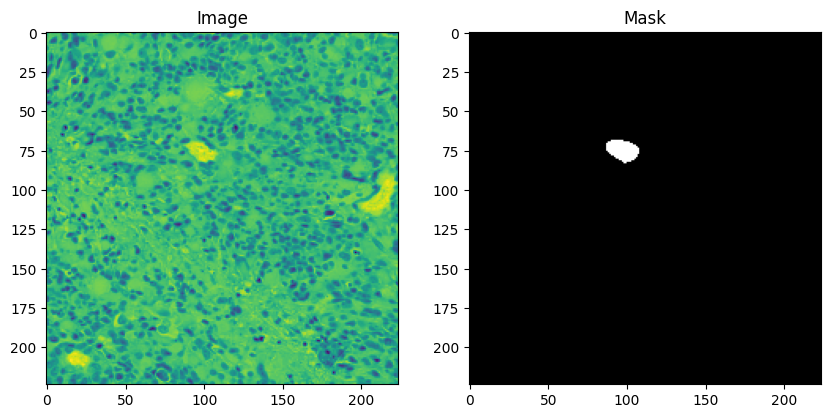

Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-0.9059) tensor(1.) tensor(0.) tensor(1.)


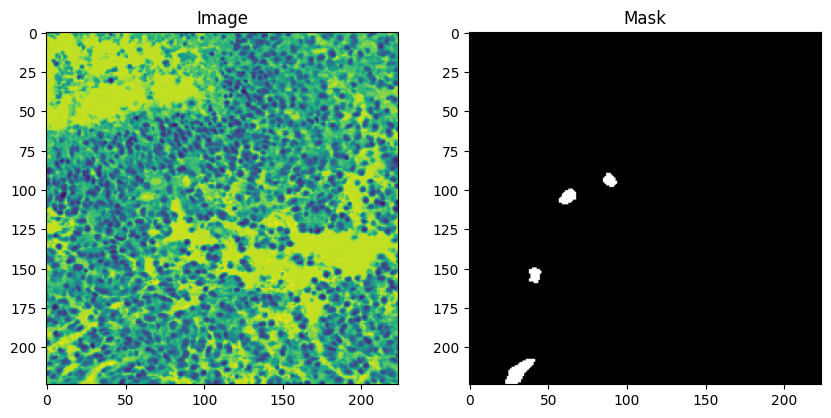

Shape of the input data: 
torch.Size([16, 3, 224, 224]) torch.Size([16, 1, 224, 224])
Min and Max of the input data: 
tensor(-0.8353) tensor(1.) tensor(0.) tensor(1.)


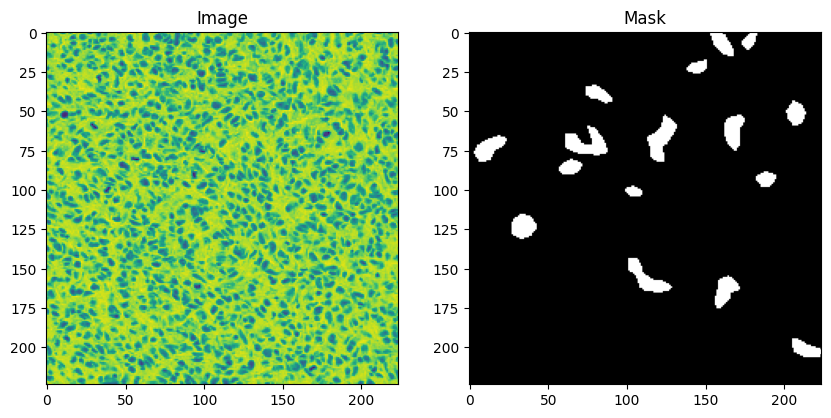

Train size : 34
Validation size : 9
Test size : 4


In [11]:
dataset = DataLoaderManager(
    root_dir="../patches", kidney_dir=None, data_augmentation=False, shape=(image_size,image_size), 
    test_dir="../patches/patches_test/patches_anno_medecin_bvd_mask"
)

test_set = DataLoaderManager(
    root_dir="../patches/patches_test", test_set=True, 
    shape=(image_size,image_size), test_dir="../patches/patches_test/patches_anno_medecin_bvd_mask"
)

train_size = int(train_size * len(dataset))
val_size = len(dataset) - train_size 

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

dataset.show_data(train_loader)
dataset.show_data(val_loader)
dataset.show_data(test_loader)

print(f"Train size : {len(train_loader)}")
print(f"Validation size : {len(val_loader)}")
print(f"Test size : {len(test_loader)}")

In [19]:
smp.encoders.encoders.keys()

dict_keys(['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_effic

## Model Training
- Encoder can be one of : 
    - 'vgg16', 'vgg19', 
    - 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
    - 'efficientnet-b3'


In [20]:
encoder_name = 'efficientnet-b3'
# encoder_name = 'mit_b4'
# encoder_name = "resnet34"
model = smp.Unet(encoder_name=encoder_name, encoder_weights='imagenet', classes=num_classes, in_channels=3)
model = model.to(device)
optimizer = torch.optim.AdamW
loss = Loss.combined_bce_loss
trainer = Trainer()
pos_weight = trainer.calculate_weights(train_loader)
pos_proba = trainer.calculate_proba(train_loader)
print(f"Positive weights : {pos_weight}")
print(f"Positive proba : {pos_proba}")
history = trainer.set_model(model)\
    .set_loader(train_loader, val_loader, test_loader)\
    .set_loss_fn(loss)\
    .set_optimizer(optimizer)\
    .fit(learning_rate, epochs, pos_proba=None, pos_weight=None)

Positive weights : 73.08568809844186
Positive proba : 0.01349788367587601
Training the model on cuda...
Validating...
Epoch [1/50], Training Loss: 0.837584896999247, Validation Loss: 0.7916379570960999
Validating...
Epoch [2/50], Training Loss: 0.7574783511021558, Validation Loss: 0.718707819779714
Validating...
Epoch [3/50], Training Loss: 0.6987472159021041, Validation Loss: 0.6731538308991326
Validating...
Epoch [4/50], Training Loss: 0.6533120467382318, Validation Loss: 0.6334963970714145
Validating...
Epoch [5/50], Training Loss: 0.6187789317439584, Validation Loss: 0.6042137940724691
Validating...
Epoch [6/50], Training Loss: 0.5887366901425755, Validation Loss: 0.5813105503718058
Validating...
Epoch [7/50], Training Loss: 0.5689033900990206, Validation Loss: 0.5597189995977614
Validating...
Epoch [8/50], Training Loss: 0.5463874234872705, Validation Loss: 0.540229770872328
Validating...
Epoch [9/50], Training Loss: 0.5228674367946737, Validation Loss: 0.5185092621379428
Validati

## Model saving 
- Path explanation : 
    - [MODEL NAME]\_[MODEL VERSION]\_[LOSS]\_[OPTIMIZER]\_[WEIGHTED CLASS]\_[AUGMENTED DATA]\_[IMAGE_CHANNELS]\_[NUMBER CLUSTERS]\_[NUMBER EPOCHS]

In [21]:
suffix = "model_RES34_FOCAL_DICE_balanced_augmented_3D"

model_path = f"../res/model_params/{suffix}"
history_path = f"../res/model_metrics/{suffix}"

trainer.save(model_path, history_path)

Saving the model...
Model saved.


## Plotting results

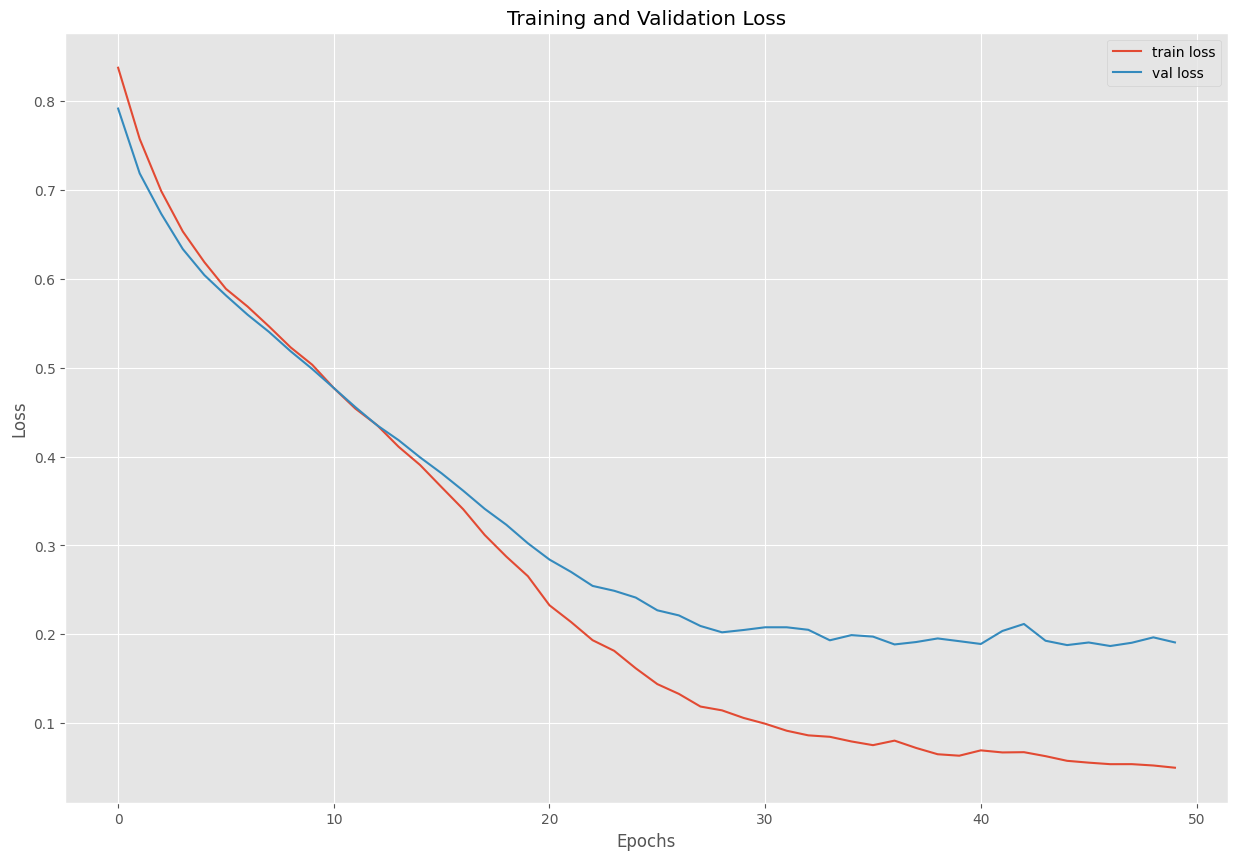

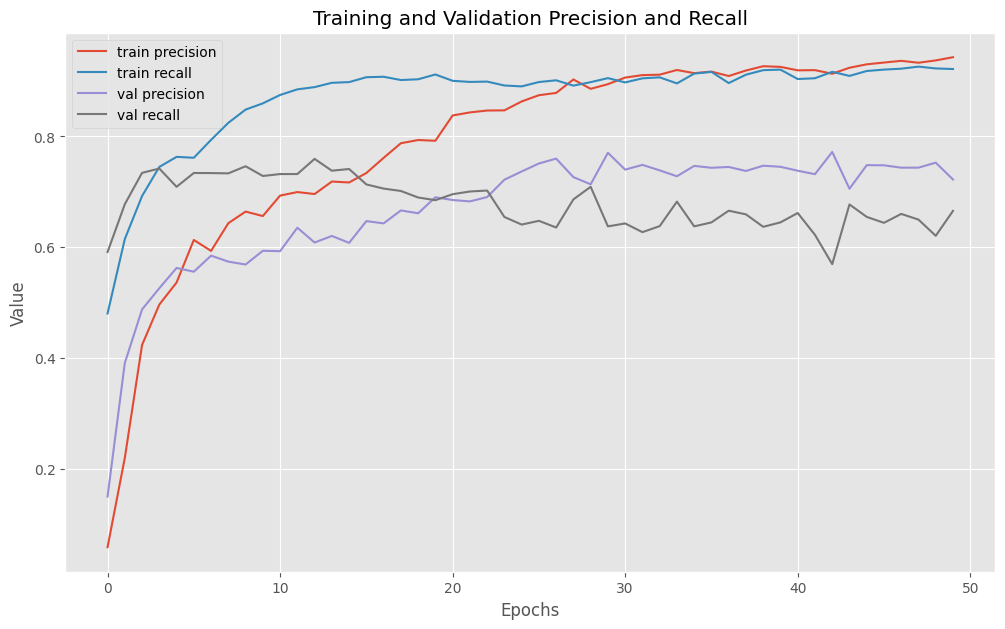

In [22]:
train_loss = history['training']['loss']
val_loss = history['validation']['loss']
precision = history['training']['precision']
recall = history['training']['recall']
val_p = history['validation']['precision']
val_r = history['validation']['recall']

trainer.plot_loss(train_loss, val_loss)
trainer.plot_precision_recall(precision, recall, val_p, val_r)

## Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


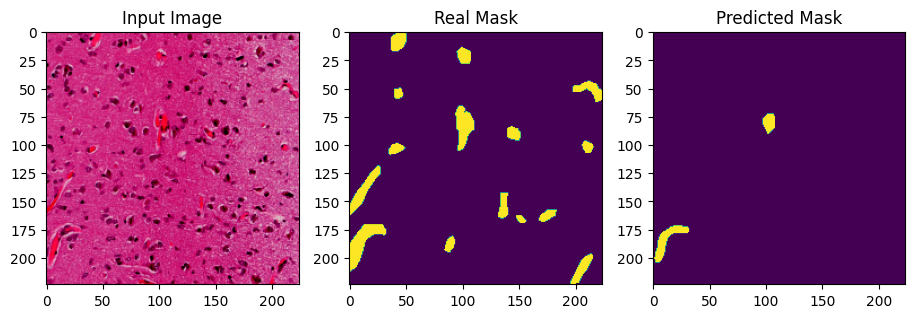

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


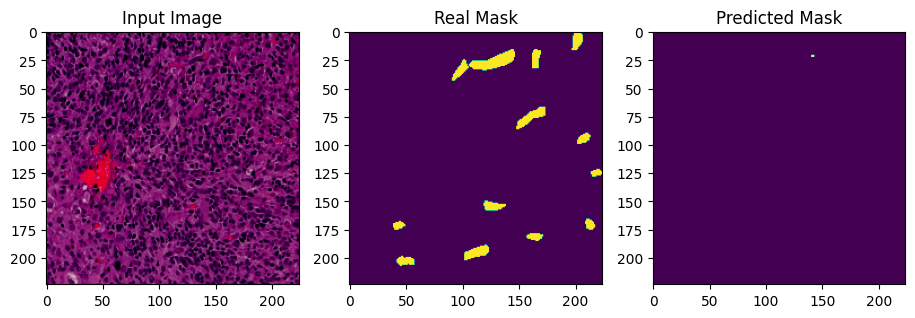

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


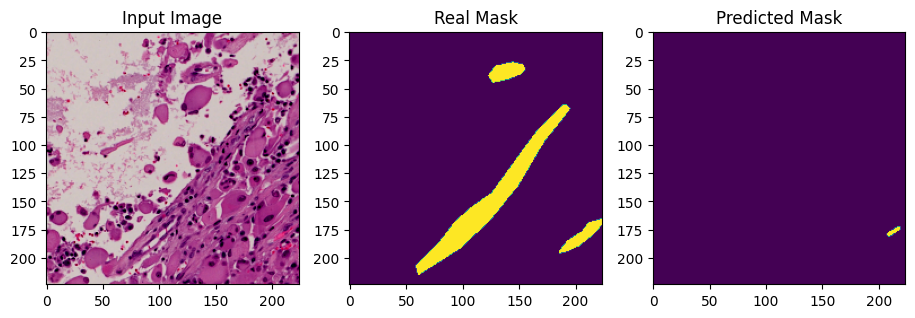

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


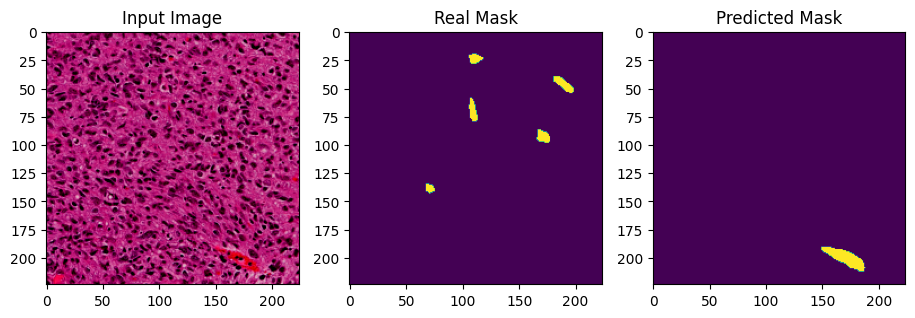

In [18]:
# model_path = f"../res/model_params/{suffix}"
encoder_name = 'mit_b4'
model_path = "../res/model_params/model_with_focal_dice_MIT/model_MITB4_FOCAL_DICE_balanced_augmented_3D"

tester = Tester(state=model_path, test_loader=test_loader, encoder_name=encoder_name)
# tester.evaluate()
tester.predict_loader(test_loader, max_images=10, has_target=True)